# Defining the general form functions

### Creating the tiles based on the input external field values of JPOs

In [5]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

def create_sub_vectors(h_values):
    N = len(h_values) 
    nodeCnt = int((np.sqrt(8*N + 17) - 1) / 2)  # Calculate N from the array size
    h_indices = range(N)
    
    # Putting fix JPOs inside the subvector
    sub_vector = h_indices[0 :  nodeCnt - 2]
    sub_vectors = []
    
    coupler_indices = []
    sub_vectors.append(sub_vector)

    start_index = nodeCnt -2
    for size in range(nodeCnt-1, 0, -1):
        sub_vector = h_indices[start_index : start_index + size]
        sub_vectors.append(sub_vector)
        start_index += size

    for subCnt in range(nodeCnt-2):
        coupler_indice = []
        for subCnt2 in range(nodeCnt-2-subCnt):
            #print("index1: ",subCnt, "index2: ",subCnt2)
            if subCnt==0:
                couplerIndexes = np.array([sub_vectors[subCnt][subCnt2], sub_vectors[subCnt+1][subCnt2], sub_vectors[subCnt+1][subCnt2+1], sub_vectors[subCnt+2][subCnt2]])
            else:
                couplerIndexes = np.array([sub_vectors[subCnt][subCnt2+1], sub_vectors[subCnt+1][subCnt2], sub_vectors[subCnt+1][subCnt2+1], sub_vectors[subCnt+2][subCnt2]])

            coupler_indice.append(couplerIndexes)
        coupler_indices.append(coupler_indice)

    return coupler_indices

### Print the output indices for the LHZ pyramid

In [6]:
def print_pyramid(array):
    pyramid_height = len(array)

    for i in range(pyramid_height - 1, -1, -1): 
        for j in range(len(array[i])):
            print("{ ", end="")
            for k in range(len(array[i][j])):

                print(array[i][j][k], end=" ")
            print("}", end=" ")
        
        print()

### Draw LHZ structure based on the external fields and interactions

In [7]:
def draw_LHZ(J_values, h_values):
    pyramid_nodes = len(h_values)
    nodeCnt = int((np.sqrt(8*pyramid_nodes + 17) - 1) / 2)
    pyramid_base = h_values[0:nodeCnt-2]

    print("N = ", nodeCnt)
    print()

    k = nodeCnt-2
    print("  ", h_values[len(h_values)-1])
    print(" /","   \\")

    for i in range(2, nodeCnt-1):
        for j in range(i-1):
            print(h_values[k+j] ," ", J_values[j], " ", end='')
        print(h_values[k+j+1])

        print()


    for i in range(1,nodeCnt-2):
        print(h_values[i])
    print()
    for p in range(len(pyramid_base)):
        print(" \\","   /",end='')
    print()
    for p in range(len(pyramid_base)):
        print(" ",h_values[p]," ",end='')
    print()

        
    
J_values = np.array([1, 1, 1]) # Coupling strength
h_values = np.array([0.1, 0.1, -0.1, -0.1, -0.1, 0.1, 0.1, -0.1])  # Magnetic field strengths
draw_LHZ(J_values, h_values)

N =  4

   -0.1
 /    \
-0.1   1  -0.1

0.1

 \    / \    /
  0.1    0.1  


### Calculate the LHZ Hamiltonian based on quadratic equations

In [8]:
def calc_LHZ_Ham(J_values, h_values, coupler_indices):
    N = len(h_values)  # Number of spins
    JPOCnt = N
    nodeCnt = (np.sqrt(8*N + 17) - 1) / 2
    CouplerCnt = int(((nodeCnt - 1) * (nodeCnt - 2)) / 2)

    print("Number of JPOs & couplers: " ,JPOCnt, " & ", CouplerCnt)
    print("")

    # Create the spin operators for N spins
    spin_operators = [qt.sigmaz() for _ in range(N)]
    spin_interactors = [qt.sigmaz() for _ in range(N)]

    # Create the Hamiltonian for the Ising model in one tile
    Imatrix = qt.qeye(2)
    H = qt.Qobj()
    H_interaction = [qt.Qobj() for _ in range(CouplerCnt)]
    Htot = qt.Qobj()

    # Create the single-spin term in the Hamiltonian
    for i in range(N):
        spin_temp= [Imatrix for _ in range(N)]
        spin_temp[i] = spin_operators[i]
        spin_kronecker = qt.tensor(spin_temp)
        H += h_values[i] * spin_kronecker

    Hcntr = 0
    # Create the interaction terms in the Hamiltonian
    for i in range(len(coupler_indices)):
        for j in range(len(coupler_indices[i])):
            interact_temp = [Imatrix] * N
            for k in range(len(coupler_indices[i][j])):
                interact_temp[coupler_indices[i][j][k]] = spin_interactors[coupler_indices[i][j][k]]

            interact_kronecker = qt.tensor(interact_temp)
            H_interaction[Hcntr] = -1*J_values[Hcntr] * interact_kronecker
            Hcntr = Hcntr + 1
    
    #print("H cntr check:", Hcntr)
    
    if N > 1:
        Htot = H + sum(H_interaction)
    else:
        Htot = H

    stateSize = 2 ** len(h_values)
    print("Hamiltonian matrix size:", stateSize," X " , stateSize)

    return Htot


### Plot the minimum states and their energies 

In [9]:
def show_states(energies, tempstates, nodeCnt):
    fig = plt.figure()
    ax = fig.add_axes([0.1, 0.1, 0.9, 0.9])

    ax.plot(tempstates, energies)
    #for j in tempstates:
    #    binary_labels.append(format(j, '0{length}b'.format(length=nodeCnt)))

       
    binary_labels = [bin(val)[2:] for val in tempstates]
    ax.set_xlabel('States')
    ax.set_xticks(tempstates)
    ax.set_xticklabels(binary_labels)
    ax.set_ylabel('Energy')
    ax.grid()
    plt.xticks(rotation=90,fontsize=6)
    
    #dpi = 300
    #plt.savefig('states.png', dpi=dpi)

    plt.show()

### Find the repeated states and remove them from answers

In [10]:
def find_repeated_values(vector):
    unique_values, counts = np.unique(vector, return_counts=True)
    repeated_values = unique_values[counts > 1]
    indices_array = [np.where(vector == value)[0] for value in repeated_values]
    
    return repeated_values, indices_array

### Check the validity condition of LHZ. The number of ones in the plaquette should be even

In [11]:
def LHZ_validity_check(minima_indices, coupler_indices):
    
    nodeCnt = len(coupler_indices[0]) + 2
    JPO_num = int((nodeCnt * (nodeCnt - 1)) /2 + nodeCnt - 2)

    # Calculating where the last row is fixed
    fixStateVal = 0
    for fcntr in range(len(coupler_indices[0])):
        fixStateVal += int(2**coupler_indices[0][fcntr][0])
    
    unique_set = set(minima_indices)
    unique_array = list(unique_set)
    binary_minima_state = []

    valid_states_num = 0
    tempval2 = ""
    for j in unique_array:
        
        compare_val = fixStateVal & j
        if compare_val == fixStateVal:
            tempval = format(j, '0{length}b'.format(length=JPO_num))
            binary_minima_state.append(tempval)

            for l in range(len(coupler_indices)):
                for m in range(len(coupler_indices[l])):
                    temp_validity = 0
                    for n in range(len(coupler_indices[l][m])):
                        temp_validity += int(tempval[coupler_indices[l][m][n]])
                    
                    if (temp_validity % 2 == 0) & (tempval2 != tempval):
                        valid_states_num += 1
                        #print("Valid state = ", tempval)
                        tempval2 = tempval


    valid_percentage = 100 * valid_states_num / len(binary_minima_state)
    
    return valid_percentage

### calculate the output state of the system and generate the answer states

In [12]:
def correct_state_evaluation(h_values, HamiltonVal, coupler_indices):
    statesVal = []
    stateSize = 2 ** len(h_values)
    nodeCnt = len(coupler_indices[0]) + 2

    state = []
    for _ in range(nodeCnt):
        state.append(True)

    for i in range(stateSize):
        ket1 = qt.basis(stateSize, i)  # input ket calculation
        statesVal.append(HamiltonVal.matrix_element(ket1,ket1))

    vector = np.real(statesVal)
    
    #modify the vector to get the energy
    #vectest = np.real(state)
    #vectortemp = np.abs(statesVal)
    #vector = vectortemp
    #for i in range(len(vectest)):
    #    if vectest[i] < 0:
    #      vector[i] = -1 * vectortemp[i]
    

    local_minima = np.r_[True, vector[1:] < vector[:-1]] & np.r_[vector[:-1] < vector[1:], True]

    minima_indices = np.where(local_minima)[0]

    tempstates = []
    minima_indice_vals = []

    bitFlipIndice = 0

    # Calculating where the last row is fixed
    fixStateVal = 0
    for fcntr in range(len(coupler_indices[0])):
        fixStateVal += int(2**coupler_indices[0][fcntr][0])

    for j in range(len(minima_indices)):
        # Perform bitwise logical AND operation
        result = minima_indices[j] & fixStateVal

        tempState = 0
        tempRevState = 0
        #& (vector[minima_indices[j]] < -10):
        if (result == fixStateVal):
            
            bitFlipIndice = 2**coupler_indices[0][0][1]
            
            if (int(minima_indices[j]/bitFlipIndice)%2 == 0):
                state[1] = not state[0]
            else:
                state[1] = state[0]

            for i in range(2, nodeCnt):
                bitFlipIndice = 2**coupler_indices[0][i-2][2]
                if (int(minima_indices[j]/bitFlipIndice)%2 == 0):
                    state[i] = not state[i-1]
                else:
                    state[i] = state[i-1]

            for k in range(nodeCnt):
                tempState += int(state[k]) * (2**k)
                tempRevState += int((not state[k])) * (2**k)

            tempstates.append(tempState)
            minima_indice_vals.append(minima_indices[j])
            #tempstates.append(tempRevState)

    repeated_values, indices_array = find_repeated_values(tempstates)

    tempstates = []
    energies = []

    for i in range(len(repeated_values)):
        
        tempstates.append(repeated_values[i])
        
        tempenergy = 0
        for j in range(len(indices_array[i])):
            tempenergy += vector[minima_indice_vals[j]]
        
        energies.append(tempenergy)

    tempstates2 = np.array(tempstates)

    val_percentage = LHZ_validity_check(minima_indices, coupler_indices)
    print("Validity percentage: ", val_percentage, "%")

    binary_string = []

    for j in tempstates2:
        binary_string.append(format(j, '0{length}b'.format(length=nodeCnt)))

    #Plot states
    show_states(energies, tempstates2, nodeCnt)

    return(binary_string)

### Testing LHZ Ising machine code

{ 3 5 6 7 } 
{ 0 2 3 5 } { 1 3 4 6 } 

Number of JPOs & couplers:  8  &  3

Hamiltonian matrix size: 256  X  256
Validity percentage:  100.0 %


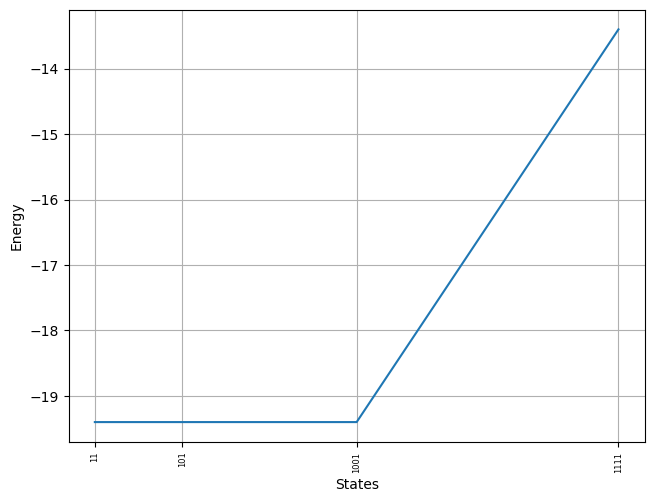

The correct states: 4
['0011', '0101', '1001', '1111']


In [13]:
# 3-node example
#J_values = np.array([-10]) # Coupling strength
#h_values = np.array([0.1, -0.1, 0.1, -0.1])  # Magnetic field strengths

# 4-node example
J_values = np.array([1, 1, 2])*1 # Coupling strength
h_values = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])  # Magnetic field strengths

# 5-node example
#J_values = 1 * np.array([2, 2, 2, 5, 2, 5]) # Coupling strength
#h_values = 1 * np.array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2])  # Magnetic field strengths

# 6-node example (takes too long!)
#J_values = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) # Coupling strength
#h_values = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])  # Magnetic field strengths

coupler_indices = create_sub_vectors(h_values)
print_pyramid(coupler_indices)
print("")

HamiltonVal = qt.Qobj()
HamiltonVal = calc_LHZ_Ham(J_values, h_values, coupler_indices)
binary_string = correct_state_evaluation(h_values, HamiltonVal, coupler_indices)

print("The correct states:", len(binary_string))
print (binary_string)